In [1]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, RNN, Lambda, Concatenate
from keras.layers.merge import Multiply
from keras.models import Model
from keras.losses import mean_squared_error, binary_crossentropy
from keras.models import Model
import keras.backend as K
# from keras.losses import mean_squared_error

Using TensorFlow backend.


# Right now make as many assumptions as possible

It's better to ask it
- derive speeds
- separate x and y. mby use same module for both?
- learn bounces separately
     - is LSTM much better if there is only 1 frame after the bounce vs 0?

In [98]:
def save_model(model, model_str):
    model_json = model.to_json()
    with open('trained/'+model_str+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights('trained/'+model_str+".h5")
    print("Saved model to disk")

In [2]:
## Straight movement, derive speed

from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, RNN, Lambda

# This returns a tensor
inputs = Input(shape=(4,1,))
# inputs = Input(shape=(10,1))

# a layer instance is callable on a tensor, and returns a tensor
x = LSTM(4, return_sequences=False)(inputs)
x = Dense(2)(x)

predictions = x#Dense(2, input_shape=(4,1))(x)

# This creates a model that includes
# the Input layer and three Dense layers
model_ws = Model(inputs=inputs, outputs=predictions)
model_ws.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_ws.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
Total params: 106
Trainable params: 106
Non-trainable params: 0
_________________________________________________________________


In [3]:
df = pd.read_csv('sim_data2.csv')
# x, x_vel, y, y_vel
a = df.to_numpy()
a = a.reshape((20000,5,4)) #samples x timesteps x features
X = a[:,:4,0].reshape(20000,4,1) #np.delete(a, [1,3], axis=2)[:,:10,:]
Y = a[:,4,:2] #.reshape(10000,5,2)

train_X = X[:8000]
train_Y = Y[:8000]

# test_X = X[8000:]
# test_Y = Y[8000:]
model_ws.fit(train_X, train_Y, epochs=200, verbose=False) #200 seems reasonable

In [4]:
import matplotlib.pyplot as plt

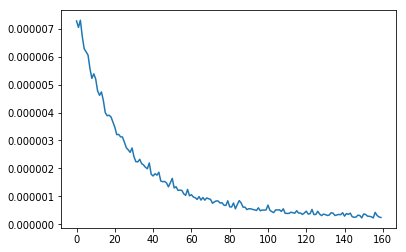

In [5]:
plt.plot(model_ws.history.history['loss'][40:])

In [6]:
test_X = X[8000:]
test_Y = Y[8000:]
rmse(test_Y, model_ws.predict(test_X))

0.000573794208119709

In [7]:
rmse(train_Y, model_ws.predict(train_X))

0.0005788387534677802

In [8]:
model_ws.predict(train_X[[100]])

array([[0.5643273 , 0.02134169]], dtype=float32)

In [101]:
save_model(model_ws, 'model_ws')

Saved model to disk


# Bounces

In [10]:
inputs = Input(shape=(2,))

x = Dense(2)(inputs)
x = Dense(2)(x)
x = Dense(2)(x)
predictions = x#Dense(4, input_shape=(4,1))(x)

# This creates a model that includes
# the Input layer and three Dense layers
model_b = Model(inputs=inputs, outputs=predictions)
model_b.compile(loss=binary_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 6         
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


In [18]:
df = pd.read_csv('bounces_mirror.csv')
a = df.to_numpy()
a = a.reshape((20000,2,4)) #samples x timesteps x features
a = a[:,:,:2]
train_X = a[:1800,0,:]
test_X = a[1800:,0,:]
train_Y = a[:1800,1,:]
test_Y = a[1800:,1,:]
model_b.fit(train_X, train_Y, epochs=600, verbose=False) #e = 150 is enough

In [95]:
save_model(model_b, 'model_b')

Saved model to disk


In [19]:
print(rmse(test_Y, model_b.predict(test_X)))
print(rmse(train_Y, model_b.predict(train_X)))

0.9952715597681688
0.9825344576644824


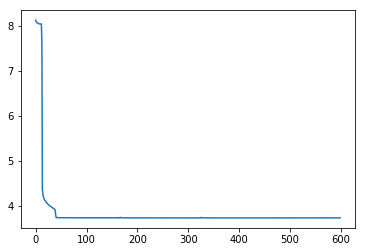

In [20]:
import matplotlib.pyplot as plt
plt.plot(model_b.history.history['loss'][0:])
plt.show()

In [21]:
train_X[[0,1]]

array([[ 1.06517512,  0.091181  ],
       [-0.00969421, -0.01684606]])

In [22]:
model_b.predict(train_X[[0,1]])

array([[-1.0485501 , -0.0956835 ],
       [ 0.00963123,  0.01687105]], dtype=float32)

In [23]:
train_Y[[0,1]]

array([[ 0.93482488, -0.091181  ],
       [ 0.00969421,  0.01684606]])

In [ ]:
model_json = model_b.to_json()
with open("sim_e1500_b.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_b.save_weights("model_e1500_b.h5")
print("Saved model to disk")

### Attention

In [24]:
inputs = Input(shape=(1,))
x = Dense(8)(inputs)
x = Dense(20, activation='relu')(x)
x = Dense(2, activation='softmax')(x)
predictions = x

model_att = Model(inputs=inputs, outputs=predictions)
model_att.compile(loss=binary_crossentropy,
              optimizer='adamax',
              metrics=['accuracy'])
model_att.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_6 (Dense)              (None, 20)                180       
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 42        
Total params: 238
Trainable params: 238
Non-trainable params: 0
_________________________________________________________________


In [28]:
df = pd.read_csv('bounces_att.csv')
a = df.to_numpy()
train_X = a[:,0].reshape(20000,1)
train_Y = (a[:,2] == True)

l = train_X.shape[0]
i = np.arange(l)
t = np.zeros((l, 2))
t[:,0] = 1-train_Y
t[:,1] = train_Y
train_Y = t

model_att.fit(train_X, train_Y, epochs=100, verbose=False)

In [96]:
save_model(model_att, 'model_att')

Saved model to disk


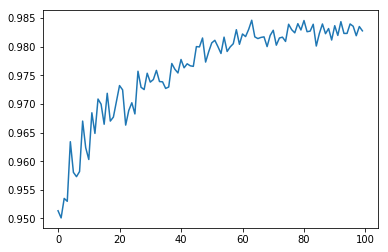

In [29]:
plt.plot(model_att.history.history['acc'])

In [30]:
inputs = Input(shape=(1,))

x = model_att(inputs)
x = Lambda(lambda s: K.round(s))(x)
predictions = x
model_lambda = Model(inputs=inputs, outputs=predictions)
model_lambda.compile(loss=binary_crossentropy,
              optimizer='adam',
              metrics=['acc'])
model_lambda.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
model_3 (Model)              (None, 2)                 238       
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
Total params: 238
Trainable params: 238
Non-trainable params: 0
_________________________________________________________________


In [97]:
save_model(model_lambda, 'model_lambda')

Saved model to disk


## Bounce series

In [33]:
df = pd.read_csv('bounces_x_1.csv')
a = df.to_numpy()
a = a.reshape((1000,5,4))

X = a[:,:4,0].reshape(1000,4,1) #np.delete(a, [1,3], axis=2)[:,:10,:]
Y = a[:,4,:2] #.reshape(10000,5,2)

train_X = X[:800]
train_Y = Y[:800]

test_X = X[800:]
test_Y = Y[800:]

In [62]:
isBounce = K.tf.convert_to_tensor([0,1],dtype=np.float32) #if attention outputs this, then bounce module is needed

inputs_rec = Input(shape=(4,1), name='input_rec')
rec = model_ws(inputs_rec)
rec_x = Lambda(lambda s: K.reshape(s[:,0], (-1,1)))(rec)
bnc = model_b(rec)
att = model_att(rec_x)
att2 = Lambda(lambda s: K.switch(K.equal(s[0], isBounce), s[1], s[2]))([att, bnc, rec]) #~hard attention

x = att2

model_m = Model(inputs=inputs_rec, outputs=x)
model_m.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_rec (InputLayer)          (None, 4, 1)         0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 2)            106         input_rec[0][0]                  
__________________________________________________________________________________________________
lambda_24 (Lambda)              (None, 1)            0           model_1[24][0]                   
__________________________________________________________________________________________________
model_3 (Model)                 (None, 2)            238         lambda_24[0][0]                  
__________________________________________________________________________________________________
model_2 (M

In [99]:
save_model(model_m, 'model_m')

Saved model to disk


In [64]:
df2 = pd.read_csv('sim_data_borders.csv')
# x, x_vel, y, y_vel
a2 = df2.to_numpy()
a2 = a2.reshape((4000,5,4)) #samples x timesteps x features
X2 = a2[:,:4,0].reshape(4000,4,1) #np.delete(a, [1,3], axis=2)[:,:10,:]
Y2 = a2[:,4,:2] #.reshape(10000,5,2)

train_X2 = X2[:8000]
train_Y2 = Y2[:8000]

In [66]:
model_m.predict(train_X2[:5])

array([[ 0.6150022 , -0.0253206 ],
       [ 0.4859036 , -0.02526301],
       [ 0.35669184, -0.02541319],
       [ 0.22752744, -0.02571928],
       [ 0.43480444,  0.06677724]], dtype=float32)

In [67]:
train_Y2[:5]

array([[ 0.61450047, -0.02578439],
       [ 0.4855785 , -0.02578439],
       [ 0.35665653, -0.02578439],
       [ 0.22773456, -0.02578439],
       [ 0.4343477 ,  0.06713727]])

In [74]:
rmse(model_m.predict(train_X2), train_Y2)

0.02372510040926766

In [77]:
df2.shape

(20000, 4)

In [73]:
mixdf = pd.concat([df, df2[:5000]])
mix = mixdf.to_numpy()
mix = mix.reshape(2000,5,4)
np.random.shuffle(mix)
mix_train_x = mix[:1800,:4,0].reshape(1800,4,1)
mix_train_y = mix[:1800,4,:2]
mix_test_x = mix[1800:,:4,0].reshape(200,4,1)
mix_test_y = mix[1800:,4,:2]
rmse(mix_test_y, model_m.predict(mix_test_x)) # My model

0.03305186186485594

In [75]:
from sklearn.metrics import mean_squared_error

In [76]:
mean_squared_error(model_m.predict(train_X2), train_Y2)

0.0005628803894298323

## Modules without attention

In [70]:
# n2n model
inputs = Input(shape=(4,1))
x = LSTM(4, return_sequences=False)(inputs)
x = Dense(4)(x)
x = Dense(8)(x)
x = Dense(20)(x)
x = Dense(2)(x)
x = Dense(2)(x)
model_n2n = Model(inputs=inputs, outputs=x)
model_n2n.compile(loss=mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
model_n2n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 4, 1)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_13 (Dense)             (None, 20)                180       
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 42        
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 6         
Total para

In [78]:
model_n2n.fit(mix_train_x, mix_train_y, epochs=100)

Epoch 1/100
1800/1800 [==============================] - 1s 592us/step - loss: 0.1224 - acc: 0.9439
Epoch 2/100
1800/1800 [==============================] - 0s 175us/step - loss: 0.0100 - acc: 0.9894
Epoch 3/100
1800/1800 [==============================] - 0s 168us/step - loss: 0.0072 - acc: 0.9894
Epoch 4/100
1800/1800 [==============================] - 0s 172us/step - loss: 0.0061 - acc: 0.9894
Epoch 5/100
1800/1800 [==============================] - 0s 160us/step - loss: 0.0054 - acc: 0.9894
Epoch 6/100
1800/1800 [==============================] - 0s 162us/step - loss: 0.0049 - acc: 0.9894
Epoch 7/100
1800/1800 [==============================] - 0s 164us/step - loss: 0.0046 - acc: 0.9894
Epoch 8/100
1800/1800 [==============================] - 0s 161us/step - loss: 0.0045 - acc: 0.9894
Epoch 9/100
1800/1800 [==============================] - 0s 167us/step - loss: 0.0044 - acc: 0.9894
Epoch 10/100
1800/1800 [==============================] - 0s 166us/step - loss: 0.0043 - acc: 0.9894

1800/1800 [==============================] - 0s 161us/step - loss: 0.0014 - acc: 0.9850
Epoch 83/100
1800/1800 [==============================] - 0s 160us/step - loss: 0.0014 - acc: 0.9844
Epoch 84/100
1800/1800 [==============================] - 0s 158us/step - loss: 0.0013 - acc: 0.9839
Epoch 85/100
1800/1800 [==============================] - 0s 160us/step - loss: 0.0013 - acc: 0.9850
Epoch 86/100
1800/1800 [==============================] - 0s 158us/step - loss: 0.0013 - acc: 0.9839
Epoch 87/100
1800/1800 [==============================] - 0s 161us/step - loss: 0.0013 - acc: 0.9839
Epoch 88/100
1800/1800 [==============================] - 0s 159us/step - loss: 0.0013 - acc: 0.9844
Epoch 89/100
1800/1800 [==============================] - 0s 159us/step - loss: 0.0014 - acc: 0.9867
Epoch 90/100
1800/1800 [==============================] - 0s 160us/step - loss: 0.0013 - acc: 0.9839
Epoch 91/100
1800/1800 [==============================] - 0s 159us/step - loss: 0.0013 - acc: 0.9844
Epo

In [100]:
save_model(model_n2n, 'model_n2n')

Saved model to disk


In [80]:
mean_squared_error(mix_test_y, model_n2n.predict(mix_test_x))

0.0013999252131424566

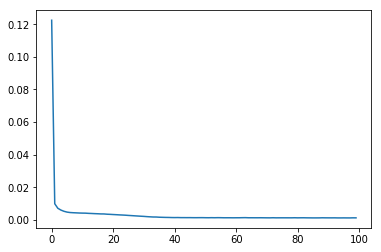

In [87]:
plt.plot(model_n2n.history.history['loss'])